# Detailed LIME example.

For this example we employ the Iris dataset that provides four attributes that can be used to classify flowers into three classes. 

Using this dataset we fit a Decision Tree as our original ML model, we then generate a number of random instances with the four attributes and use the Decision Tree to classify them. We then use LIME to fit a regression model that identifies which of the four attributes have the greatest impact in the model's classifications.

If we compare the structure of the decision tree to the output from LIME we can appreciate that they yield similar results. LIME concludes that only two of the four attributes play a significant role in the tree's decisions, petal width and length, and from the structure of the tree we can confirm that that is the case.

In [1]:
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn import tree
from sklearn import linear_model

# Reading the contents of the iris dataset for testing purposes.
data_set = datasets.load_iris()
np.set_printoptions(threshold=np.inf)

# Number of perturbed samples to be generated.
n = 100000
# Number of bins for the histograms of continous attributes.
num_bins = 25

Compute means and standard deviations for each of the four attributes. Just for reference.

In [2]:
means_data = np.mean(data_set.data, axis=0)
std_dev_data = np.std(data_set.data, axis=0)
print("Feature\t\t\tMean\t\t\tStd. Dev.")
for j in range(0, len(data_set.feature_names)):
    print(data_set.feature_names[j], "\t", means_data[j], "\t",
          std_dev_data[j])

Feature			Mean			Std. Dev.
sepal length (cm) 	 5.843333333333335 	 0.8253012917851409
sepal width (cm) 	 3.057333333333334 	 0.43441096773549437
petal length (cm) 	 3.7580000000000027 	 1.7594040657753032
petal width (cm) 	 1.199333333333334 	 0.7596926279021594


## Machine Learning model that is to be interpreted.

Use the Iris dataset to fit a model, a Decision Tree, that we'll use later to classify the random samples we generate.

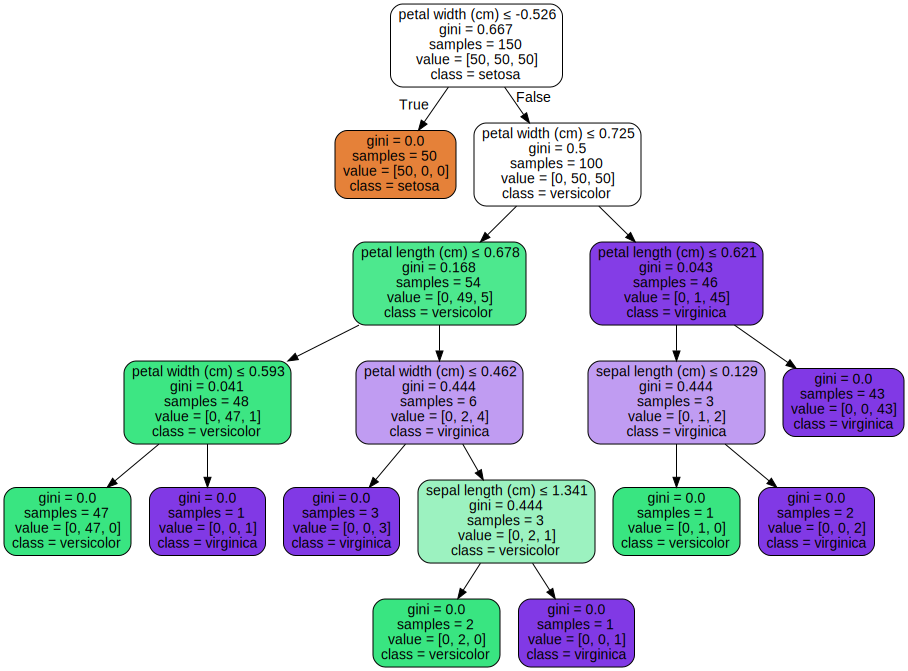

In [3]:
# Fitting a decision tree model to the iris dataset.
data_norm = preprocessing.scale(data_set.data)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_norm, data_set.target)
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data_set.feature_names,
                                class_names=data_set.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)

# graph.render creates a PDF file with a diagram of the structure
# of the decision tree. This file is stored in the local directory.
# graph.render("iris")

# graph creates a diagram of the structure of a decision tree and
# displays it in the notebook.
graph

## LIME Functions

These functions generate random samples of the selected attributes, discrete (discrete_rand_samples) or continuous (continuous_rand_samples), and compute the LIME interpretation (lime_fit).

In [4]:
def lime_sample(n, continuous, np_vector, num_bins):
    """
    Generates n random values with distribution provided as input.

    Inputs are:
    - Desired number random samples, n.
    - A boolean value indicating whether the input vector contains
      continous values (True) or discrete values (False), continuous.
    - The vector of values that describes the distribution of the
      random samples that are to be generated, np_vector.
    - Desired number of bins for the histogram, num_bins. If
      continuous=True, this value is ignored.
 
    If continuous, the domain of values in np_vector is broken down
    into num_bins buckets, and the frequency of samples for each bin
    is computed. The frequency determines the number of random
    samples to be generated for each bucket, and each random sample
    generated is chosen from a uniform probability distribution with
    end values equal to those of the corresponding bucket.
    
    If discrete, the frequencies of each class are computed and used
    to generate random values with the corresponding multinomial 
    distribution.
    
    Output is the vector rand that contains n random samples with the
    appropriate distribution.
    """
    
    if continuous:
        # Normalize data to mean zero and std. dev of one
        np_vector = preprocessing.scale(np_vector)
    
        # Compute frequency of instances in each of the num_bins buckets.
        freqs, h_bins = np.histogramdd(np_vector, bins=num_bins)
        freqs = freqs/np.sum(freqs)
    
        # h_bins lists the bin edges in the distribution.
        h_bins = np.asarray(h_bins[0])
        rand = np.zeros(1)
    
        # samples_bins dictates how many random instances have
        # to be generated in each bin.
        samples_bins = np.random.multinomial(n, freqs, 1)
    
        # The for loop uses a uniform distribution to generate
        # the desired number of instances in each bucket of the
        # distribution.
        for j in range(0, len(freqs)):
            samples = np.random.uniform(h_bins[j], h_bins[j+1],
                                        samples_bins[0][j])
            rand = np.hstack((rand, samples))
        rand = rand[1:, ]
    else:
        # Extract the list of unique values in np_vector, and the
        # frequency of each value.
        values, freqs = np.unique(np_vector, return_counts=True)
        freqs = freqs/np.sum(freqs)
        values = values.astype(float)
    
        # Normalize values to mean zero and unit variance.
        values = preprocessing.scale(values)
    
        # Using a multinomial distribution, determine the number
        # of instances of each class that are to be generated.
        multinom_rand = np.random.multinomial(n, freqs, 1)[0]
    
        # rand will contain the list of instances that are generated
        # based on the numbers in multinom_rand.
        rand = np.zeros(n)
        k = 0
        for j in range(0, len(values)):
            rand[k:k+multinom_rand[j]] = values[j]
            k = k + multinom_rand[j]
    return(rand)


def lime_fit(x, x_class, perturbed_samples, class_perturb_samples):
    """
    Computes LIME linear model coefficients.

    Inputs are:
    - x, the instance from the original ML model we are trying to
      explain.
    - x_class, the classification assigned to x by the original ML
      model.
    - perturbed_samples which are the random perturbations of inputs
      that were generated.
    - class_perturb_samples which are the classifications assigned to
      each of the perturbations by the original ML model.
      
    Outputs are:
    - Coefficients for the LIME linear model.
    - The intercept for the LIME linear model.
    - List of LIME weights that were computed for each instance
      in perturbed_samples.
    """

    # Compute LIME weights.
    sigma = np.var(np.sum((perturbed_samples - x)**2, axis=1))
    l_weights = np.exp(-np.sum((perturbed_samples - x)**2, axis=1) /
                       sigma)
    
    # l_weights = lime_weights(x, perturbed_samples)
    
    # We identify the correct class for the instance we wish to
    # interpret, make that class one and all others become
    # class zero.
    lime_class = class_perturb_samples == x_class
    lime_class = lime_class.astype(int)

    # Multiply the LIME weights by the perturbed samples and the
    # original ML model's output.
    perturb_weighted = (perturbed_samples.T * l_weights).T
    class_weighted = class_perturb_samples * l_weights

    # Using the perturbed samples and the above classification, we fit
    # the LIME linear model using LASSO.
    reg = linear_model.LassoCV(eps=0.001, n_alphas=100, cv=5)
    # reg = linear_model.Lasso(alpha=0.01)
    reg.fit(perturb_weighted, class_weighted)
    return(reg.coef_, reg.intercept_, l_weights)

The code below tests generation of n discrete random numbers based on the distribution of the input vector. This is for testing the function, not necessary for the example.

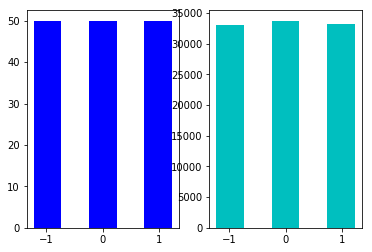

In [5]:
# Generate n random samples with the same probability distribution
# as the classifications of the 150 instances in the Iris dataset.
# Random samples and original values are normalized for the
# comparison.
# output = discrete_rand_samples(n, data_set.target)
output = lime_sample(n, False, data_set.target, 0)
values = preprocessing.scale(data_set.target.astype(float))

# Visualizing the output.
fig, ax = plt.subplots(1, 2)
ax[0].hist(values, bins=5, color="b")
ax[1].hist(output, bins=5, color="c")
plt.show()

## Interpreting the output of the Decision Tree using LIME.

We now take the 150 instances of the Iris dataset, attributes only, and form them we generate n random samples with similar distributions in the values of each attribute.

In [6]:
# Bucketizing each attribute from the Iris dataset and
# generating perturbed samples with the same distribution.
perturbed_samples = np.zeros(n)
for j in range(0, data_set.data.shape[1]):
    array = data_set.data[:, j]
    output = lime_sample(n, True, array, num_bins)
    perturbed_samples = np.vstack((perturbed_samples, output))
perturbed_samples = np.transpose(perturbed_samples[1:, ])

The code and plots below are used to verify that the distribution of each normalized attribute in the Iris dataset, and that of the normalized attributes of the random samples we have generated are the same.


Iris dataset:



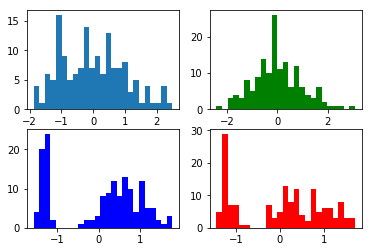


Perturbed samples:



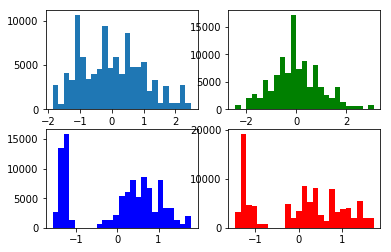

In [7]:
# Normalized iris dataset
print("\nIris dataset:\n")
fig, ax = plt.subplots(2, 2)
ax[0, 0].hist(data_norm[:, 0], bins=num_bins)
ax[0, 1].hist(data_norm[:, 1], bins=num_bins, color="g")
ax[1, 0].hist(data_norm[:, 2], bins=num_bins, color="b")
ax[1, 1].hist(data_norm[:, 3], bins=num_bins, color="r")
plt.show()

# Perturbed samples
print("\nPerturbed samples:\n")
fig, ax = plt.subplots(2, 2)
ax[0, 0].hist(perturbed_samples[:, 0], bins=num_bins)
ax[0, 1].hist(perturbed_samples[:, 1], bins=num_bins, color="g")
ax[1, 0].hist(perturbed_samples[:, 2], bins=num_bins, color="b")
ax[1, 1].hist(perturbed_samples[:, 3], bins=num_bins, color="r")
plt.show()

Once random samples with the right distributions for each attribute have been generated, we provide them as input to the Decision Tree we fitted earlier, and obtain the classification for each.

In [8]:
class_perturb_samples = clf.predict(perturbed_samples)

We select a single instance from the Iris dataset. This is the instance we will try to interpret using LIME.

In [9]:
# Selecting the instance to interpret.
inst_num = np.round(np.random.uniform(0, data_set.data.shape[0], 1))
inst_num = inst_num[0].astype(int)
x = data_norm[inst_num, :]
x_class = data_set.target[inst_num]

## Calling LIME function to get intepretation.

In [10]:
# We now fit the LIME linear model to get the coefficients and
# intercept, as well as the weight of each random sample, 
# based on its L2 distance to the instance that is being
# interpreted.
lime_beta, lime_intercept, lime_weights = lime_fit(x,
                                                   x_class,
                                                   perturbed_samples,
                                                   class_perturb_samples)

# Print output of LIME results.
print("Instance to be interpreted:")
for j in range(0, len(lime_beta)):
    print("Feature: ", data_set.feature_names[j], "\tvalue: ",
          data_set.data[inst_num, j], "\tnormalized value: ",
          data_norm[inst_num, j])
print("Classification: ",
      data_set.target_names[data_set.target[inst_num]],
      data_set.target[inst_num])
print("\nSignificant coefficients from LIME adjusted linear model:")
for j in range(0, len(lime_beta)):
    if(lime_beta[j] != 0):
        print("Feature: ", data_set.feature_names[j],
              "\tCoefficient: ", lime_beta[j])
print("Intercept: ", lime_intercept)

Instance to be interpreted:
Feature:  sepal length (cm) 	value:  4.5 	normalized value:  -1.6276883929597172
Feature:  sepal width (cm) 	value:  2.3 	normalized value:  -1.7433568431321513
Feature:  petal length (cm) 	value:  1.3 	normalized value:  -1.3970639535363667
Feature:  petal width (cm) 	value:  0.3 	normalized value:  -1.18381211071744
Classification:  setosa 0

Significant coefficients from LIME adjusted linear model:
Feature:  petal length (cm) 	Coefficient:  0.0003457664892609643
Feature:  petal width (cm) 	Coefficient:  0.713481004687955
Intercept:  0.8913758549315585


## Intepreting the results

We selected the Decision Tree for this example because it provides an output that is interpretable; the structure of the tree itself. An examination of this structure reveals that in almost all cases, branching decisions are made based on either petal length or petal width, wich is what our LIME linear model is indicating, as the LIME coefficients for sepal length and sepal width are zero.

Below we plot the random samples and the instance that is being interpreted on the petal length vs. petal width plane and, as we can observe, classes can be separated for the most part by looking at these two attributes. Note that those random samples that were classificated differently from the instance we are interpreting are merged into a single out-of-class representation.

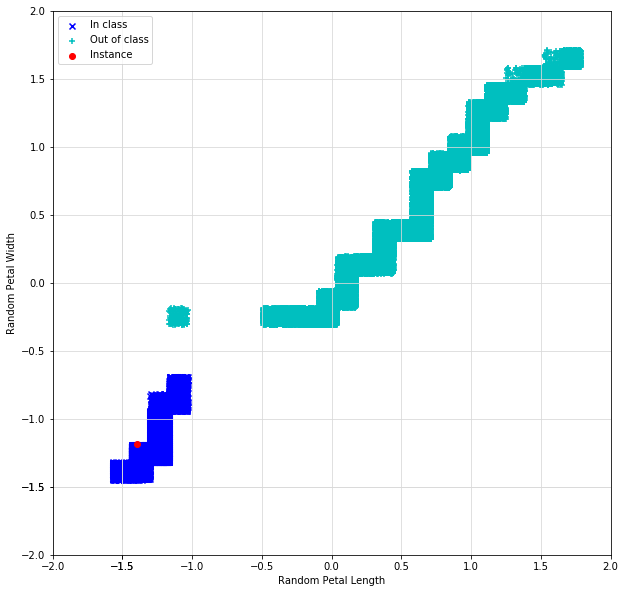

In [11]:
# For visualization we separate perturbed samples classified
# by the decision tree as in-class, from those classified
# out-of-class.
full_data = np.column_stack((perturbed_samples,
                             class_perturb_samples))
in_class_data = full_data[full_data[:, 4] ==
                          data_set.target[inst_num]]
out_class_data = full_data[full_data[:, 4] !=
                           data_set.target[inst_num]]

plt.rcParams['figure.figsize'] = [10.0, 10.0]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(in_class_data[:, 2], in_class_data[:, 3], marker='x',
           c='b', label='In class')
ax.scatter(out_class_data[:, 2], out_class_data[:, 3], marker='+',
           c='c', label='Out of class')
ax.scatter(data_norm[inst_num, 2], data_norm[inst_num, 3],
           marker='o', c='r', label='Instance')
ticksx = ax.set_xticks([-2, -1.5, -1, -1.5, -0.5, 0, 0.5, 1, 1.5, 2])
ticksy = ax.set_yticks([-2, -1.5, -1, -1.5, -0.5, 0, 0.5, 1, 1.5, 2])
plt.grid(b=True, which='both', color='0.85', linestyle='-')
ax.set_xlabel('Random Petal Length')
ax.set_ylabel('Random Petal Width')
plt.legend(loc='upper left')

Finally, we separate all instances by how they were classified by the Decison Tree and compute the value of the LIME regression for each instance, as well as that of the instance we are explaining and plot the results.

We can see that the output of our LIME regression model separates all three classes for the most part.

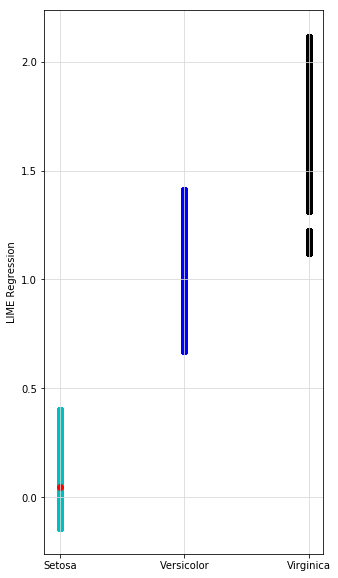

In [12]:
# Compute all LIME regression values for all perturbed samples
# and for the instance to be explained.
zero_class_reg = full_data[full_data[:, 4] == 0]
zero_class_reg = (lime_beta[2]*zero_class_reg[:, 2] +
                  lime_beta[3]*zero_class_reg[:, 3] + lime_intercept)
one_class_reg = full_data[full_data[:, 4] == 1]
one_class_reg = (lime_beta[2]*one_class_reg[:, 2] +
                 lime_beta[3]*one_class_reg[:, 3] + lime_intercept)
two_class_reg = full_data[full_data[:, 4] == 2]
two_class_reg = (lime_beta[2]*two_class_reg[:, 2] +
                 lime_beta[3]*two_class_reg[:, 3] + lime_intercept)
instance = (lime_beta[2]*data_norm[inst_num, 2] +
            lime_beta[3]*data_norm[inst_num, 3] + lime_intercept)

# Plot all LIME regression values for perturbed samples
# against their classificaton by the decision tree.
plt.rcParams['figure.figsize'] = [5.0, 10.0]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(np.zeros(len(zero_class_reg)), zero_class_reg,
           marker='o', c='c')
ax.scatter(np.zeros(len(one_class_reg))+1, one_class_reg,
           marker='o', c='b')
ax.scatter(np.zeros(len(two_class_reg))+2, two_class_reg,
           marker='o', c='k')
ax.scatter(data_set.target[inst_num], instance,
           marker='o', c='r')
ticksx = ax.set_xticks([0, 1, 2])
labelsx = ax.set_xticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_ylabel('LIME Regression')
plt.grid(b=True, which='both', color='0.85', linestyle='-')